# Why a data quality analysis?
Before we get started on core analysis, we need to sanity check the data - check for missing values, measurement problems, and joining issues - and take a peek at how the variables are distributed.

This prepatory work will allow us to catch and fix data problems, correctly interpret our results, and guide the rest of the analysis.


## tl;dr: summary of data problems
- We're missing unique ids for a third of customers. Not focusing on customers in analysis, so not a big deal.
- The transactions appear to be a (very small) random sample from a much larger dataset. That will affect summaries of product profits throughout the analysis.
- Nevertheless, the shape of the distributions of transactions per customer and per store look reasonable, and give us confidence that we can use the transaction records to understand overall Foodmart trends, if not store-specific results.

## Where does this data come from?
The Foodmart data appears to have been drawn from a data warehouse: there is a central fact table of transactions, and dimension tables for products, product families, and promotions.

Some quick context is in order: in Data Warehouse "star schemas", fact tables store the measurements collected during particular business processes events - in this case, barcode scanning during supermarket checkout. 

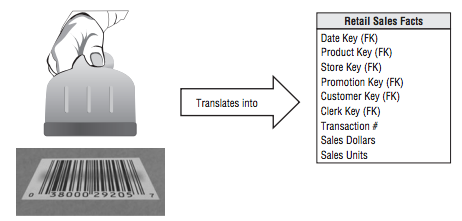

In [6]:
from IPython.display import Image
Image(filename='measurement_event.png')

*Source: [The Data Warehouse Toolkit](http://www.essai.rnu.tn/Ebook/Informatique/The%20Data%20Warehouse%20Toolkit,%203rd%20Edition.pdf) by Ralph Kimball*

Each fact consists of a physical, real-valued *measurement* - the sales price of the product being purchased, in this case - and a set of foreign keys referring to dimension tables. Dimension tables capture the *context* around the measurement - the who, what, where, and when. (For the curious, data warehouses use star schemas because they are more intuitive for analysts and performant for aggregate queries.)

Generally, if an organization has gone through the trouble of designing a warehouse and ETL'ing data from dozens of operational systems into it, they've also made sure that events are being measured correctly and reliably, and that the fact tables satisfy *referential integrity* - that every foreign key in the fact table can be matched to a primary key in the dimension table. In other words, that no measurements are missing context. The data cleaning we had to do raises some red flags, however, so we better kick the tires.

Since transactions are the heart of everything, we'll look at them first. For each table, we'll look count the number of records, overall and grouped by variable.


In [4]:
from os import environ
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Load cleaned datasets into DataFrame from Make through env variables.
dataset_paths = ['../' + dataset for dataset in environ['datasets'].split()]
product, product_class, promotion, transactions = [pd.read_pickle(path) for path in dataset_paths]


NameError: name 'environ' is not defined

## Transactions

How many transactions are there?

In [4]:
num_transactions = transactions.shape[0]
num_transactions

173602

Are any of the variables missing values?

In [5]:
transactions.isnull().sum()

product_id       0
customer_id      0
store_id         0
promotion_id     0
month_of_year    0
quarter          0
the_year         0
store_sales      0
store_cost       0
unit_sales       0
fact_count       0
dtype: int64

Lookin' good! None of our columns have missing values. We're not missing any sales price, cost, or unit measurements, and none of our foreign keys are missing!

Right?

Wait... what if some of our numerical values are just using "0" to represent null values? Let's count the number of 0's for all of our numerical variables:

In [6]:
dtypes = transactions.dtypes
numerical_cols = dtypes[(dtypes == 'float64') | (dtypes == 'int64')].index
num_0_values_by_col = (transactions[numerical_cols] == 0).sum()
num_0_values_by_col

product_id           0
customer_id      63627
store_id             0
promotion_id     63627
month_of_year        0
the_year             0
store_sales          0
store_cost           0
unit_sales           0
fact_count           0
dtype: int64

Uh oh, looks like both promotions and customers have 63,627 missing values! What percentage the transactions does this represent?

In [7]:
num_0_values_by_col['customer_id']/num_transactions

0.36651075448439535

Over a third of the dataset! How can this be?

For promotions, 0 probably represents "null" - it makes sense that one in three transactions did not occur through a promotion. For customers, however, either third of transaction are missing customers, or 1 in 3 transactions were performed by a single customer, which doesn't make sense.

It's striking, however, that the `promotion_id` and `customer_id` columns have the same number of 0 values. Maybe null promotions are associated with "0" customer_ids? This could point to a data collection problem.

In [8]:
zero_customer = transactions[transactions.customer_id == 0].index
zero_promotion = transactions[transactions.promotion_id == 0].index
set(zero_customer) & set(zero_promotion)

set()

Nope! There is not a single transactions where `promotion_id` and `customer_id` are both 0. This is very strange, considering the have the same exact number of 0 values.

Let's make a note of this and move on.

### Customers
How many unique customers are there, excluding the duds?

In [9]:
transactions_with_customers = transactions[~(transactions.customer_id == 0)]
unique_customers = transactions_with_customers.customer_id.nunique()
unique_customers

5652

How many transactions are there per customer?

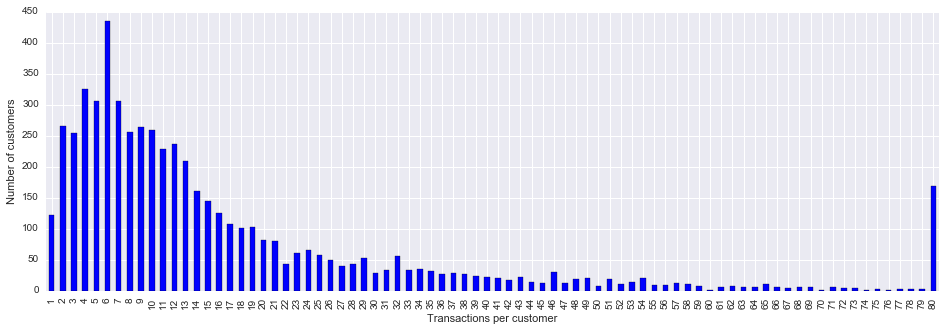

In [10]:
transactions_per_customer = transactions_with_customers.groupby('customer_id').size().clip(upper=80)
plt.figure(figsize=(16,5))
transactions_per_customer.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Transactions per customer')
plt.ylabel('Number of customers')

In [11]:
transactions_per_customer.describe()

count    5652.000000
mean       16.697452
std        17.360994
min         1.000000
25%         6.000000
50%        11.000000
75%        20.000000
max        80.000000
dtype: float64

Half of customers purchased 11 products or less in 1997. Like many count datasets bounded at zero, the distribution of transactions per customer is right-skewed due to a very long tail.

Although a median of 11 items a year seems low, the shape of the distribution makes sense: lots of people buy a couple products a few times a year, or drop in to a store for the first time and buy 8 things. The quarter of people that shop there every week will buy some variable number of products each time, which is why the tail is so long - people can end up in lots of different places.

# Promotions

We'll be analyzing promotions heavily in question two, so let's take a peak at them.

How many promotion names are there?

In [40]:
promotion.promotion_name.nunique()

51

Which of these promotion names have the most promotions associated with them?

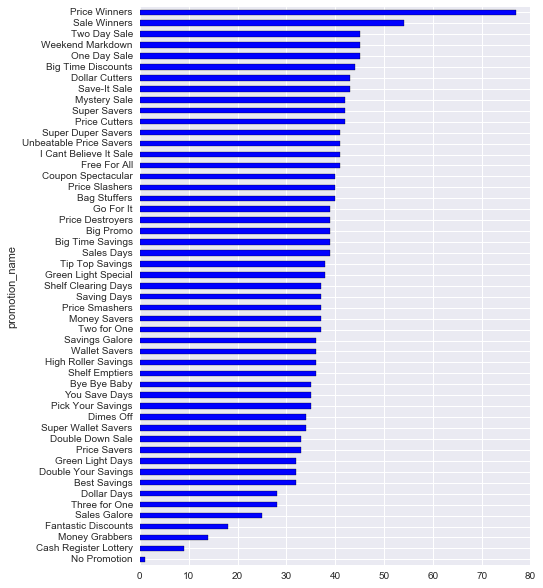

In [39]:
plt.figure(figsize=(7,10))
promotion.groupby('promotion_name').size().sort_values().plot(kind='barh')

How many _unique products_ were sold under each promotion name?

In [27]:
trans_with_promo = pd.merge(transactions, promotion, on='promotion_id')

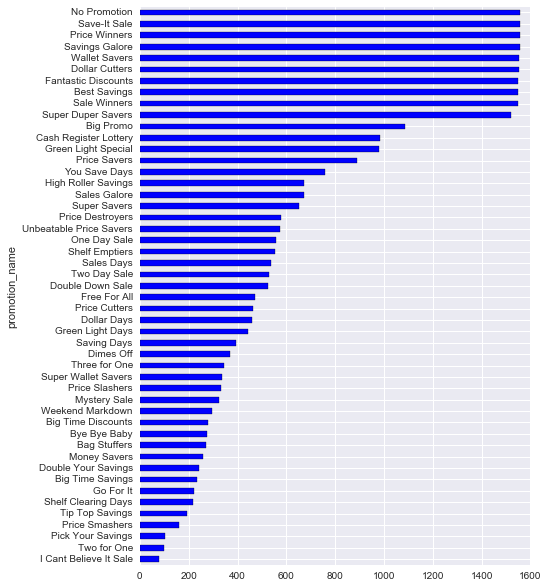

In [36]:
plt.figure(figsize=(7,10))
trans_with_promo.groupby('promotion_name')['product_id'].nunique().sort_values().plot(kind='barh')

How many media types are there?

In [15]:
promotion.media_type.nunique()

14

Which media types show up most often?

In [16]:
promotion.media_type.value_counts()

Radio                        164
Daily Paper                  162
Sunday Paper                 161
Product Attachment           161
Daily Paper | Radio          158
Cash Register Handout        157
Street Handout               155
Sunday Paper | Radio | TV    145
Daily Paper | Radio | TV     143
Sunday Paper | Radio         140
In-Store Coupon              139
TV                            90
Bulk Mail                     88
No Media                       1
Name: media_type, dtype: int64

# Checking Joins

To be able to meaningfully summarize trends in transactions, we need to join them to products and product classes. When working with new datasets, it's always important to check joins - it's possible to leave records on the table if you're not careful.

In [84]:
transactions.shape[0]

173602

### Transactions to products
Recall that we have 173,602 transactions. If we right join transactions to products on product_id, we would hope the columns from the transactions table contained 173,602 values. That would mean every transaction matched to a product in the product table.

In [88]:
trans_with_prod = pd.merge(transactions, product, on='product_id', how='right')

In [89]:
trans_with_prod.count()

product_id            173603
customer_id           173602
store_id              173602
promotion_id          173602
month_of_year         173602
quarter               173602
the_year              173602
store_sales           173602
store_cost            173602
unit_sales            173602
fact_count            173602
product_class_id      173603
brand_name            173603
product_name          173603
SKU                   173603
SRP                   173603
gross_weight          173603
net_weight            173603
recyclable_package    173603
low_fat               173603
units_per_case        173603
cases_per_pallet      173603
shelf_width           173603
shelf_height          173603
shelf_depth           173603
dtype: int64

Indeed, the transaction columns - `customer_id` to `fact_count` have 173,602 non-null values. 

The columns from the product table - `product_class_id` to `shelf_depth` - have one additional value. It appears that one of the products in the product table was unable to match to any transaction.

No big deal, this won't really affect things. We can safely do an inner join during our analysis.

### Product class
Now let's join transactions-product to product_class:

In [139]:
trans_with_prod_class = pd.merge(trans_with_prod, product_class, on='product_class_id', how='right')

In [92]:
trans_with_prod_class.count()

product_id             173603
customer_id            173602
store_id               173602
promotion_id           173602
month_of_year          173602
quarter                173602
the_year               173602
store_sales            173602
store_cost             173602
unit_sales             173602
fact_count             173602
product_class_id       173611
brand_name             173603
product_name           173603
SKU                    173603
SRP                    173603
gross_weight           173603
net_weight             173603
recyclable_package     173603
low_fat                173603
units_per_case         173603
cases_per_pallet       173603
shelf_width            173603
shelf_height           173603
shelf_depth            173603
product_subcategory    173611
product_category       173611
product_department     173611
product_family         173611
dtype: int64

It looks like all transaction-product records match to a product class record. Around 8 product_classes did not match to any product. Again, this just means there's a bit of irrelevant transaction metadata in the `product_class` table, it won't affect our analysis.

### Promotions
Let's join to promotions next. We're joining on `promotion_id`, which comes from the `transactions` table, so if every transaction matches to a promotion we'd expect to see 173,602 non-null values for all transaction-product-product_class columns in the resulting table. If promotion columns have more than 173,603 non-null values, it's because some promotion did not match to any transactions.

In [93]:
trans_prod_promo = pd.merge(trans_with_prod_class, promotion, on='promotion_id', how='right')

In [94]:
trans_prod_promo.count()

product_id               173602
customer_id              173602
store_id                 173602
promotion_id             175304
month_of_year            173602
quarter                  173602
the_year                 173602
store_sales              173602
store_cost               173602
unit_sales               173602
fact_count               173602
product_class_id         173602
brand_name               173602
product_name             173602
SKU                      173602
SRP                      173602
gross_weight             173602
net_weight               173602
recyclable_package       173602
low_fat                  173602
units_per_case           173602
cases_per_pallet         173602
shelf_width              173602
shelf_height             173602
shelf_depth              173602
product_subcategory      173602
product_category         173602
product_department       173602
product_family           173602
promotion_district_id    175304
promotion_name           175304
media_ty

In [110]:
unmatched_promotions = trans_prod_promo[trans_prod_promo.product_id.isnull()]
num_unmatched_promotions = unmatched_promotions['promotion_id'].nunique() 
num_unmatched_promotions

1702

Looks like all transactions matched to promotion. But 1702 promotions failed to match to a transaction!

In [108]:
num_unmatched_promotions / promotion.promotion_id.nunique()

0.9130901287553648

That's 91% of promotions. What's going on?

In [118]:
unmatched_promotions_by_year = unmatched_promotions.start_date.dt.year.value_counts()
unmatched_promotions_by_year

1998    623
1996    591
1997    488
Name: start_date, dtype: int64

In [121]:
(unmatched_promotions_by_year[1996] + unmatched_promotions_by_year[1998]) / unmatched_promotions_by_year.sum()

0.7132784958871915

71% of these promotions started in either 1996 or 1998, whereas all of our transaction data is from 1997:

In [125]:
transactions.the_year.value_counts()

1997    173602
Name: the_year, dtype: int64

It's a little worisome that 488 campaigns from 1997 can't be matched to a single transaction. It's unlikely that so many promotions actually spurred zero product sales, so this is likely a data quality issue. Either transaction records are missing, transaction foreign keys are missing or inaccurate, or the promotions table contains dirty promotion records. We'll need to note this issue in any conclusions pertaining to promotions.

## Transaction - revenue, costs, and profits

Let's circle back to transactions and take a look at their the revenues and costs associated with each one. Questions one and two both focus on gross profits, which are derived from costs and revenues, so we should do our diligence here.

How much total revenue did foodmart stores make in 1997?

In [132]:
total_revenue = transactions.store_sales.sum()
total_revenue

1130430.0599999998

Just over a million dollars. This seems super low: according to [this supermarket industry profile](http://classic.edsuite.com/proposals/proposals_169/88_1_intel_-_grocery_stores.pdf), the median yearly revenue for a **single** large supermarket was $14 million was in 2005. And there are multiple stores represented in this dataset. Something's up - we likely don't have every transaction from 1997 in our dataset.

Let's continue our revenue evaluation and then investigate.

In [133]:
total_costs = transactions.store_cost.sum()
total_costs

451236.03960000002

$450K in costs, for a profit of..

In [62]:
gross_profit = total_revenue - total_costs
gross_profit

679194.02040000027

In [63]:
gross_margin = gross_profit / total_revenue
gross_margin

0.60082798965908613

680K, which is a 60% gross profit margin. 

This gross profit margin - which is gross profit as a percentage of sales revenue, before deducting overhead, payroll, taxes, and so on - seems reasonable, given the high overhead costs of operating a grocery store. The net profit margin is likely much lower.

In other words, the total revenue, cost, and profit figures look reasonable in percentage terms, but not in absolute terms. Let's figure out why that is. We'll look at revenue per store first:

In [135]:
transactions.store_id.nunique()

5589

These transactions took place in over 5,000 stores! Let's look at the revenue per store:

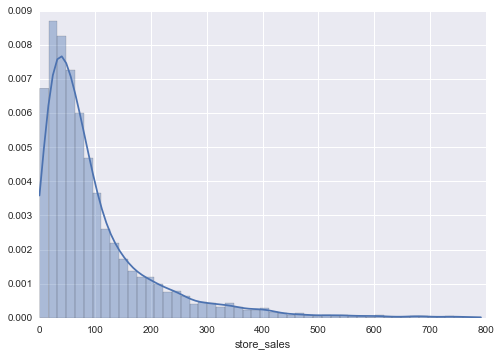

In [204]:
total_revenue_per_store = transactions.groupby('store_id')['store_sales'].sum()
# Plot distribution of total revenue by store, removing outliers so chart looks ok.
sns.distplot(total_revenue_per_store[total_revenue_per_store < 800])

In [205]:
total_revenue_per_store.describe()

count     5589.000000
mean       202.259807
std       2425.735992
min          0.570000
25%         33.250000
50%         65.950000
75%        125.770000
max      87218.280000
Name: store_sales, dtype: float64

The median store only brought in $65 during the whole year! These numbers are way too low.

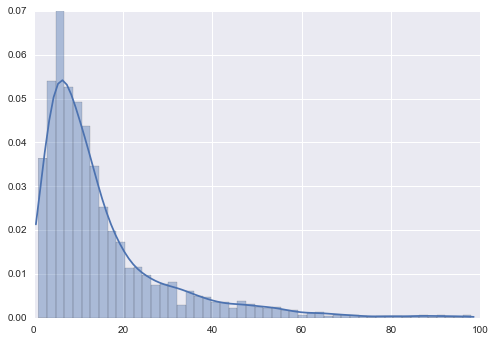

In [191]:
# Plot number of transactions per store, removing outliers so chart looks ok.
transactions_per_store = transactions.groupby('store_id').size()
sns.distplot(transactions_per_store[transactions_per_store  < 100])

In [190]:
transactions_per_store.describe()

count     5589.000000
mean        31.061371
std        365.609153
min          1.000000
25%          6.000000
50%         10.000000
75%         19.000000
max      13340.000000
dtype: float64

And here's the culprit: we have fewer than 20 transactions for 75% of stores. The _distribution_ looks reasonable, however: most stores have relative few transactions, with a long tail of stores that sell more. That suggests that `transactions.csv` could be a random sample of the original fact table.

It could be that this sample isn't random throughout 1997, and instead oversamples from certain parts of the year. Let's find a day to look at the transactions over time.


In [194]:
# Creates a time series of the number of "unmatched promotions" - promotions we couldn't join
# to any of the transactions - that started in a given week.
promotions_by_week = unmatched_promotions.set_index(unmatched_promotions.start_date)['promotion_id'] \
                                         .resample('W', how='count')

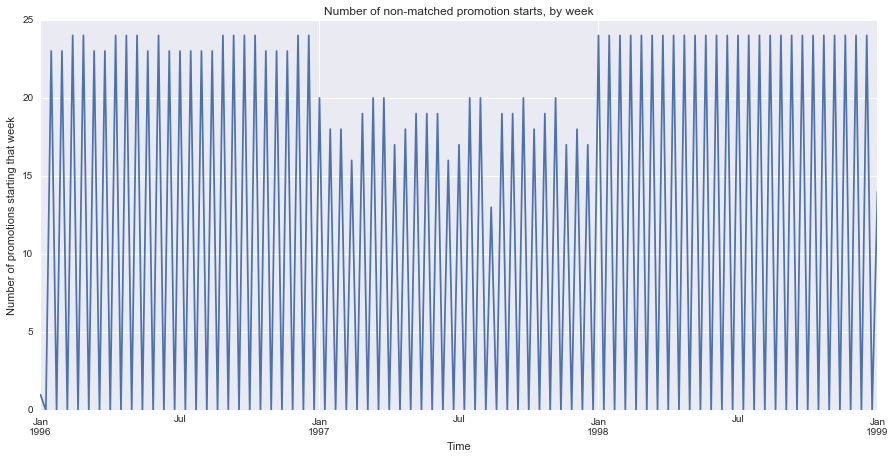

In [199]:
# Plot the time series.
plt.figure(figsize=(15,7))
promotions_by_week.plot()
plt.title('Number of non-matched promotion starts, by week')
plt.xlabel('Time')
plt.ylabel('Number of promotions starting that week')

Remember those promotions that we cound't match to any records? Let's call them "unmatched promotions."

The chart above shows the number of unmatched promotions that _started_ on any given week in 1996, 1997, and 1998.

The first thing to note is that promotions tend to start every two weeks:

In [198]:
promotions_by_week.tail(10)

start_date
1998-11-01     0
1998-11-08    24
1998-11-15     0
1998-11-22    24
1998-11-29     0
1998-12-06    24
1998-12-13     0
1998-12-20    24
1998-12-27     0
1999-01-03    14
Freq: W-SUN, Name: promotion_id, dtype: int64

And you usually have 23-24 promotions kicking off during those weeks - at least in 1996 and 1998. In other words, none of the promotions during these years were matched to the transactions, which makes sense because all transaction are from 1997.

For 1997, however, the number of unmatched promotions starting during "on" weeks ranges between 16-20. This means that about 25% of promotions _were_ matched to at least one transaction, and 75% weren't. If we assume that `transactions.csv` is a small sample of a much larger dataset, it's perfectly possible that the sample ends up without all the promotions being represented. That reinforces the random sample hypothesis, as does the fact that the number of unmatched 1997 promotions stays fairly constant from month to month.

Is our transaction sample size is 173,602, how big is the population, and what percentage of it are we sampling?

In [213]:
median_store_revenue_sample = total_revenue_per_store.describe()['50%']
median_store_revenue_population = 6000000
pct_of_pop_sampled = (median_store_revenue_sample / median_store_revenue_population) * 100
pct_of_pop_sampled

0.0010991666666666667

If we use the supermarket industry report above as a rough prior and assume that the median total revenue per store is around $6,000,000 per year, then we are probably sampling between .01% and .001% of all 1997 transactions.

In [214]:
transactions.shape[0] / pct_of_pop_sampled

157939651.25094768

That would suggest that population size is on the order of 160 million yearly transactions, which sounds much more reasonable for a larger supermarket chain data warehouse.